Source and Description of 1st dataset:

**Full link or name of the provider:** [Brent Crude Prices - Europe](https://fred.stlouisfed.org/series/DCOILBRENTEU)  
**Series code:** DCOILBRENTEU  
**Date of access:** Oct. 13, 2024  
**Description:** Crude Oil Prices: Brent - Europe, Units: Dollars per Barrel, Not Seasonally Adjusted  

Characteristics:

**Periodicity or frequency:** Daily  
**Time span:** 1987-05-20 to 2024-10-07  
**Number of observations:** 9,755  

---

Source and Description of 2nd dataset:

**Full link or name of the provider:** [WTI Crude Prices - Cushing, Oklahoma](https://fred.stlouisfed.org/series/DCOILWTICO)  
**Series code:** DCOILWTICO  
**Date of access:** Dec. 01, 2024  
**Description:** Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma, Units: Dollars per Barrel, Not Seasonally Adjusted  

Characteristics:

**Periodicity or frequency:** Daily  
**Time span:** 1986-01-02 to 2024-11-25  
**Number of observations:** 10,148  

In [4]:
def clean_data(df, value_column, window_size):
    """
    Clean the data by handling missing values, converting to numeric, 
    and mitigating outliers using a rolling mean.

    Parameters:
    df (pd.DataFrame): Input data
    value_column (str): Column to clean
    window_size (int): Rolling window size for filling missing values

    Returns:
    pd.DataFrame: Cleaned data
    """
    df[value_column] = pd.to_numeric(df[value_column], errors='coerce')
    rolling_mean = df[value_column].rolling(window=window_size, min_periods=1).mean()
    df[value_column] = df[value_column].fillna(rolling_mean)

    Q1, Q3 = df[value_column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[value_column] = df[value_column].where(
        df[value_column].between(lower, upper), rolling_mean
    )
    return df


def analyze_date_frequency(data):
    """
    Analyze gaps and irregularities in the dataset's date column.

    Parameters:
    data (pd.DataFrame): DataFrame with a 'date' column containing datetime objects.

    Returns:
    pd.Series: Day differences between consecutive dates.
    """
    date_diff = data['date'].diff().dt.days.dropna()

    print("\nDate Frequency Analysis:")
    print(date_diff.describe())

    print("\nDate Gaps (greater than 1 day):")
    print(date_diff[date_diff > 1])

    return date_diff


def ensure_daily_frequency(data):
    """
    Ensure daily frequency in the dataset by filling in missing dates 
    and interpolating missing values.

    Parameters:
    data (pd.DataFrame): DataFrame with a 'date' column or datetime index.

    Returns:
    pd.DataFrame: Dataset with daily frequency and filled missing values.
    """
    data = data.copy()
    if 'date' in data.columns:
        data.set_index('date', inplace=True)

    data.sort_index(inplace=True)

    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data.index.name = 'date'

    data = data.interpolate(method='time').bfill().ffill()
    return data


def prepare_merged_data(prices_brent, prices_wti):
    """
    Merge and process Brent and WTI price datasets.

    Parameters:
    prices_brent (pd.DataFrame): Cleaned Brent price data
    prices_wti (pd.DataFrame): Cleaned WTI price data

    Returns:
    pd.DataFrame: Merged and processed dataset
    """
    merged_data = pd.merge(prices_brent, prices_wti, on='date', how='inner')
    merged_data.set_index('date', inplace=True)
    merged_data = merged_data.interpolate(method='time').bfill().ffill()

    merged_data['y_brent_pct'] = merged_data['y_brent'].pct_change() * 100
    merged_data['y_wti_pct'] = merged_data['y_wti'].pct_change() * 100

    merged_data = merged_data.interpolate(method='time').bfill().ffill()
    merged_data = ensure_daily_frequency(merged_data)

    if merged_data.isnull().values.any():
        print("Missing Values Detected:")
        print(merged_data.isnull().sum())
        raise ValueError("Missing values remain after processing merged data.")

    return merged_data
    

def calculate_rmsfe(y_true, y_pred):
    """
    Calculate the Root Mean Squared Forecast Error (RMSFE).
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Forecasted values
    
    Returns:
    float: RMSFE value
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


1. **`clean_data`** handles missing values, converts data to numeric, and removes outliers using a rolling mean and interquartile range (IQR).
2. **`analyze_date_frequency`** checks the time gaps between consecutive dates and reports irregularities or gaps larger than one day.
3. **`ensure_daily_frequency`** ensures that the dataset has daily frequency by filling missing dates and interpolating missing values.
4. **`prepare_merged_data`** merges two datasets (Brent and WTI prices), calculates their percentage changes, fills missing values, and ensures daily frequency.
5. and **`calculate_rmsfe`** function

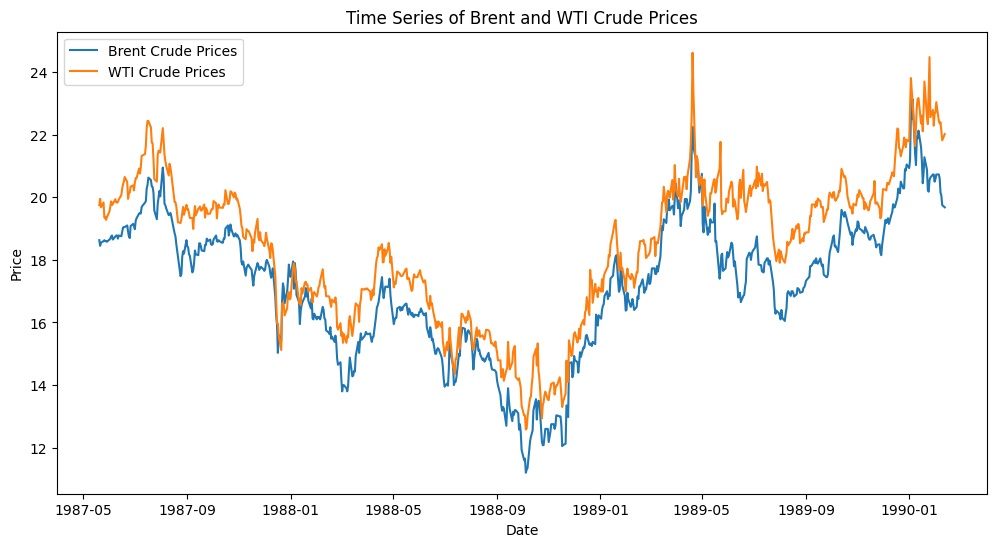


Processed Data:
              y_brent    y_wti  y_brent_pct  y_wti_pct
date                                                  
1987-05-20  18.630000  19.7500    -0.966184   1.012658
1987-05-21  18.450000  19.9500    -0.966184   1.012658
1987-05-22  18.550000  19.6800     0.542005  -1.353383
1987-05-23  18.566667  19.7325     0.451184  -0.635487
1987-05-24  18.583333  19.7850     0.360363   0.082409


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

prices_brent = pd.read_csv("./DCOILBRENTEU.csv")
prices_brent.columns = ['date', 'y_brent']
prices_brent['date'] = pd.to_datetime(prices_brent['date'])
prices_brent = clean_data(prices_brent, 'y_brent', 5)

prices_wti = pd.read_csv("./DCOILWTICO.csv")
prices_wti.columns = ['date', 'y_wti']
prices_wti['date'] = pd.to_datetime(prices_wti['date'])
prices_wti = clean_data(prices_wti, 'y_wti', 5)

merged_data = prepare_merged_data(prices_brent, prices_wti)

merged_data = merged_data.iloc[:1000]

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['y_brent'], label='Brent Crude Prices')
plt.plot(merged_data.index, merged_data['y_wti'], label='WTI Crude Prices')
plt.title('Time Series of Brent and WTI Crude Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("\nProcessed Data:")
print(merged_data.head())

In the above code we read crude oil price data from two CSV files (`DCOILBRENTEU.csv` for Brent and `DCOILWTICO.csv` for WTI).
we clean them using the `clean_data` function to handle missing values, convert data to numeric, and mitigate outliers with a rolling mean (window size = 5), merge Brent and WTI datasets into one DataFrame (`merged_data`) using the `prepare_merged_data` function, select the first 1000 rows from the merged dataset for further analysis and visualization.

# NN forecast

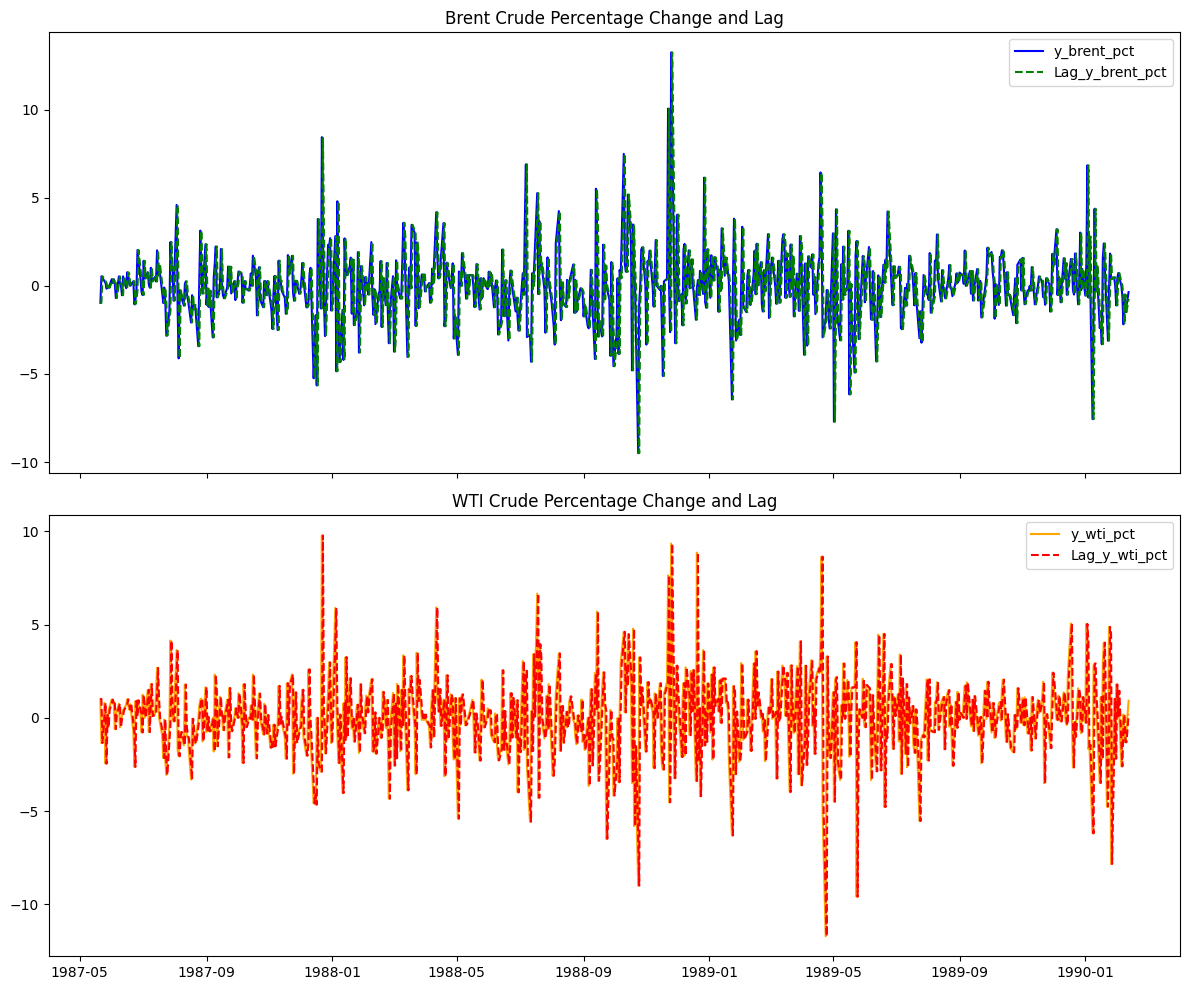

Epoch 1/1000
35/35 [==============================] - 1s 6ms/step - loss: 4.2334 - val_loss: 3.8160
Epoch 2/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.2150 - val_loss: 3.8087
Epoch 3/1000
35/35 [==============================] - 0s 7ms/step - loss: 4.1908 - val_loss: 3.8012
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 4.1845 - val_loss: 3.7942
Epoch 5/1000
35/35 [==============================] - 0s 4ms/step - loss: 4.2205 - val_loss: 3.7869
Epoch 6/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.1732 - val_loss: 3.7798
Epoch 7/1000
35/35 [==============================] - 0s 3ms/step - loss: 4.1506 - val_loss: 3.7734
Epoch 8/1000
35/35 [==============================] - 0s 4ms/step - loss: 4.1480 - val_loss: 3.7663
Epoch 9/1000
35/35 [==============================] - 0s 4ms/step - loss: 4.1683 - val_loss: 3.7598
Epoch 10/1000
35/35 [==============================] - 0s 4ms/step - loss: 4.1614 - val_loss: 3.7536

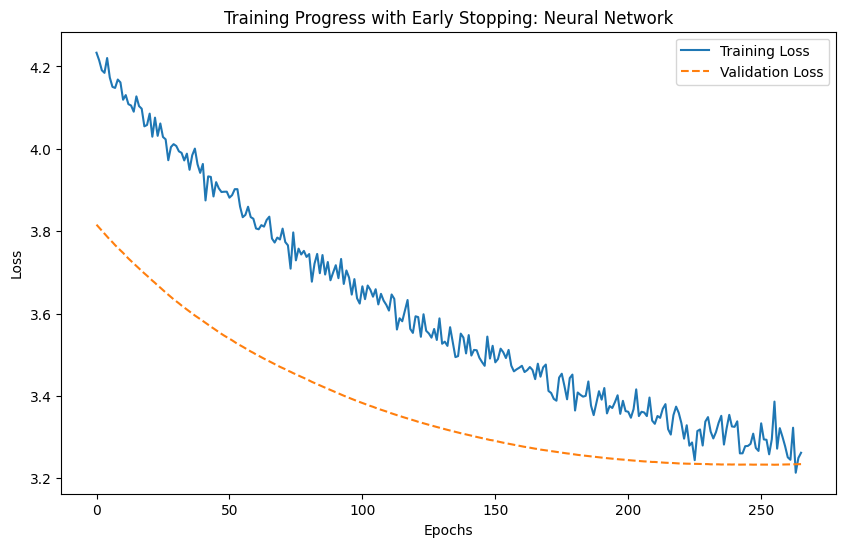

7/7 [==============================] - 0s 991us/step
Neural Network RMSE: 1.1942
Neural Network RMSFE: 1.1942


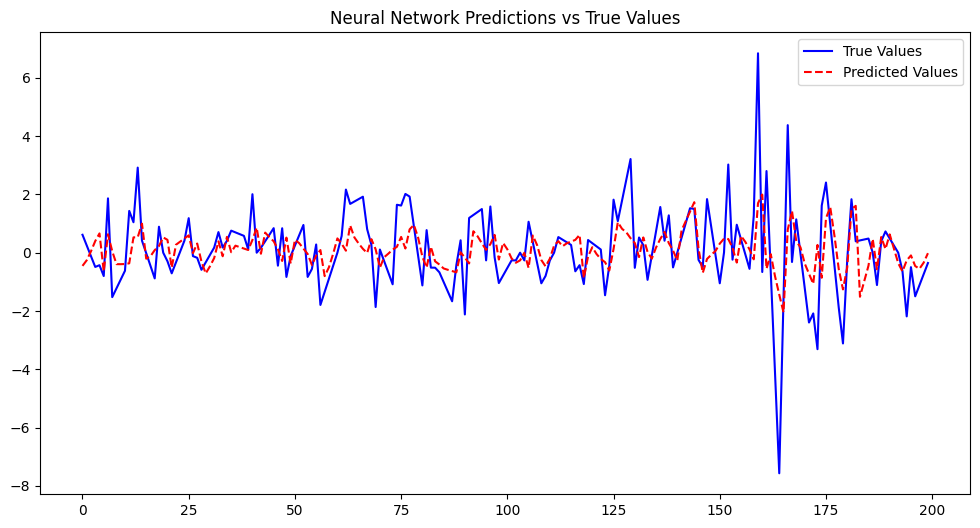

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

merged_data['Lag_y_brent_pct'] = merged_data['y_brent_pct'].shift(1) 
merged_data['Lag_y_wti_pct'] = merged_data['y_wti_pct'].shift(1)     
merged_data.dropna(inplace=True)  

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

axs[0].plot(merged_data.index, merged_data['y_brent_pct'], label='y_brent_pct', color='blue')
axs[0].plot(merged_data.index, merged_data['Lag_y_brent_pct'], label='Lag_y_brent_pct', color='green', linestyle='--')
axs[0].set_title('Brent Crude Percentage Change and Lag')
axs[0].legend()

axs[1].plot(merged_data.index, merged_data['y_wti_pct'], label='y_wti_pct', color='orange')
axs[1].plot(merged_data.index, merged_data['Lag_y_wti_pct'], label='Lag_y_wti_pct', color='red', linestyle='--')
axs[1].set_title('WTI Crude Percentage Change and Lag')
axs[1].legend()

plt.tight_layout()
plt.show()

features = ['Lag_y_brent_pct', 'Lag_y_wti_pct'] 
X = merged_data[features]
y = merged_data['y_brent_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.1),  
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)  
])

custom_lr = 0.00001  
optimizer = Adam(learning_rate=custom_lr)
model.compile(optimizer=optimizer, loss='mse')

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,          
    restore_best_weights=True  
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=1000,         
    batch_size=16,        
    validation_split=0.3,   
    verbose=1,             
    callbacks=[early_stopping] 
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress with Early Stopping: Neural Network')
plt.legend()
plt.show()

predictions = model.predict(X_test_scaled)
nn_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Neural Network RMSE: {nn_rmse:.4f}')
nn_rmsfe = calculate_rmsfe(y_test.values, predictions.flatten())
print(f'Neural Network RMSFE: {nn_rmsfe:.4f}')


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')
plt.title('Neural Network Predictions vs True Values')
plt.legend()
plt.show()

Here we want to develop and evaluate a neural network model for predicting percentage changes in Brent crude oil prices (`y_brent_pct`) based on lagged features of both Brent and WTI crude oil percentage changes. 

---

#### **Data Preprocessing and Feature Engineering**
1. **Lagged Features**:
   - Lagged versions of the Brent (`Lag_y_brent_pct`) and WTI (`Lag_y_wti_pct`) percentage change variables were created. These lagged features represent past values that are used to predict the current Brent price percentage change.
   - Rows with missing values, introduced due to lagging, were removed to ensure consistency.

2. **Data Splitting**:
   - The dataset was divided into training (80%) and testing (20%) sets without shuffling to preserve the temporal nature of the data.

3. **Standardization**:
   - Features were standardized using `StandardScaler` to improve model performance by ensuring all inputs have a similar scale, which is crucial for neural networks.

---

#### **Model Architecture**
1. **Neural Network Design**:
   - A sequential neural network was built with the following layers:
     - Input layer connected to two dense hidden layers with 64 and 32 neurons, respectively, each using ReLU activation.
     - Dropout layers with a 10% dropout rate were added after each hidden layer to prevent overfitting.
     - A single-neuron output layer was used to predict `y_brent_pct`.

2. **Optimization**:
   - The model was compiled using the Adam optimizer with a custom learning rate of 0.00001.
   - Mean Squared Error (MSE) was used as the loss function.

3. **Training Process**:
   - Early stopping was employed to stop training if the validation loss did not improve for 10 consecutive epochs, thus avoiding overfitting and reducing training time.
   - A total of 1000 epochs was set as the upper limit, but the early stopping mechanism determined the actual number of epochs.

---

#### **Evaluation and Results**
The last plot shows the **training progress of a neural network model with early stopping**, highlighting the loss on both the training and validation datasets over epochs. It represents the model's loss (error) on the training data. It steadily decreases over epochs as the model learns to fit the training data.
Also represents the model's loss on unseen validation data. The validation loss also decreases, indicating that the model is generalizing well to unseen data. The model stopped training automatically when the validation loss stabilized, preventing overfitting and ensuring the model does not train excessively after reaching its optimal performance on validation data.
The training loss fluctuates because the model continuously updates its weights during each batch, leading to temporary increases or decreases in error. The validation loss is evaluated on a fixed dataset after each epoch, providing a more stable measure of generalization without being influenced by batch-level updates and dropouts.

# Forecast comparison

1/1 [==============================] - 0s 50ms/step
1-Step-Ahead Expanding Window RMSE: 1.1879


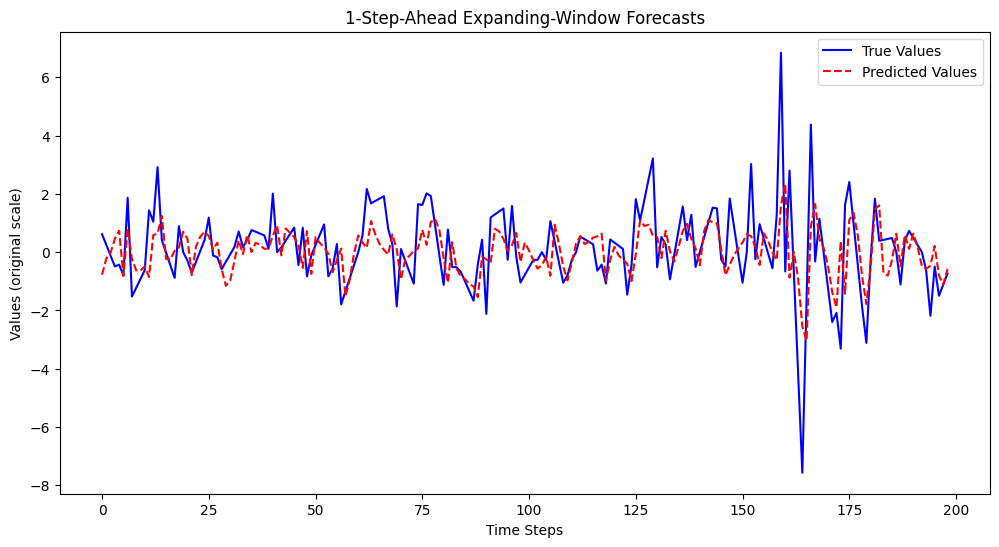

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

merged_data['Lag_y_brent_pct'] = merged_data['y_brent_pct'].shift(1)
merged_data['Lag_y_wti_pct'] = merged_data['y_wti_pct'].shift(1)
merged_data.dropna(inplace=True)

features = ['Lag_y_brent_pct', 'Lag_y_wti_pct']
target = 'y_brent_pct'

scaler = StandardScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(merged_data[features + [target]]),
    columns=features + [target],
    index=merged_data.index
)

n_initial_train = int(len(scaled_data) * 0.8)
n_total = len(scaled_data)

predictions = []
true_values = []

for i in range(n_initial_train, n_total - 1):
    train_data = scaled_data.iloc[:i]
    test_data = scaled_data.iloc[[i]]

    X_train = train_data[features].values
    y_train = train_data[target].values
    X_test = test_data[features].values
    y_test = test_data[target].values

    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(
        monitor='loss', patience=5, restore_best_weights=True, verbose=0
    )

    model.fit(X_train, y_train, epochs=20, batch_size=min(16, len(X_train)), verbose=0, callbacks=[early_stopping])

    pred = model.predict(X_test)
    predictions.append(pred[0][0])
    true_values.append(y_test[0])

temp_true = pd.DataFrame(
    np.zeros((len(true_values), len(features) + 1)),
    columns=features + [target],
    index=scaled_data.index[-len(true_values):]
)
temp_true[target] = true_values

temp_pred = pd.DataFrame(
    np.zeros((len(predictions), len(features) + 1)),
    columns=features + [target],
    index=scaled_data.index[-len(predictions):]
)
temp_pred[target] = predictions

inverse_true_values = scaler.inverse_transform(temp_true)[:, -1]
inverse_predictions = scaler.inverse_transform(temp_pred)[:, -1]

rmse = np.sqrt(mean_squared_error(inverse_true_values, inverse_predictions))
print(f'1-Step-Ahead Expanding Window RMSE: {rmse:.4f}')
expanding_nn_rmsfe = calculate_rmsfe(inverse_true_values, inverse_predictions)

plt.figure(figsize=(12, 6))
plt.plot(range(len(inverse_true_values)), inverse_true_values, label='True Values', color='blue')
plt.plot(range(len(inverse_predictions)), inverse_predictions, label='Predicted Values', color='red', linestyle='--')
plt.title('1-Step-Ahead Expanding-Window Forecasts')
plt.xlabel('Time Steps')
plt.ylabel('Values (original scale)')
plt.legend()
plt.show()

This above code implements an expanding window forecasting approach for time series data using a neural network. It preprocesses the data by scaling and creating lagged features, then iteratively trains a neural network on an expanding training set to predict one step ahead. Predictions are collected, inverse transformed, and compared to true values to calculate RMSE and RMSFE as performance metrics. Finally, it visualizes the true vs. predicted values over time.
We implemented this approach of nn in another way for comparison.

VAR One-Step-Ahead RMSE: 1.1981


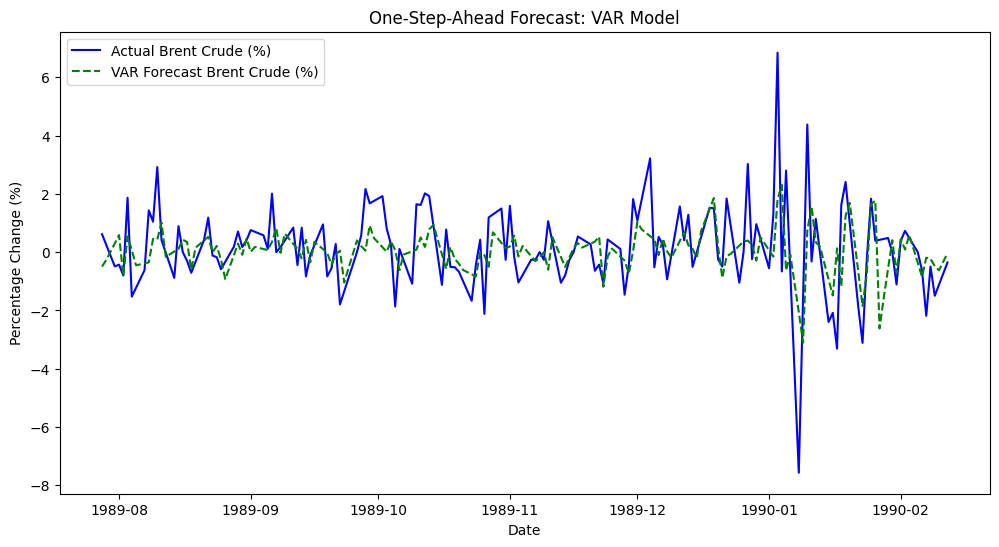

In [8]:
from statsmodels.tsa.api import VAR
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse

train_size = int(0.8 * merged_data.shape[0])
train_data = merged_data[['y_brent_pct', 'y_wti_pct']].iloc[:train_size]
test_data = merged_data[['y_brent_pct', 'y_wti_pct']].iloc[train_size:]

var_model = VAR(train_data)
optimal_lag = var_model.select_order(maxlags=15).aic
fitted_model = var_model.fit(optimal_lag)

n_fcs = test_data.shape[0]  
forecasts = []

for i in range(n_fcs):
    rolling_train = pd.concat([train_data, test_data.iloc[:i]])
    var_model = VAR(rolling_train)
    fitted_model = var_model.fit(optimal_lag)
    forecast = fitted_model.forecast(y=rolling_train.values[-optimal_lag:], steps=1)[0]
    forecasts.append(forecast)

forecast_df = pd.DataFrame(forecasts, columns=['y_brent_pct_forecast', 'y_wti_pct_forecast'], index=test_data.index)

var_rmse = rmse(test_data['y_brent_pct'], forecast_df['y_brent_pct_forecast'])
print(f'VAR One-Step-Ahead RMSE: {var_rmse:.4f}')
var_rmsfe = calculate_rmsfe(test_data['y_brent_pct'].values, forecast_df['y_brent_pct_forecast'].values)

plt.figure(figsize=(12, 6))
plt.plot(test_data['y_brent_pct'], label='Actual Brent Crude (%)', color='blue')
plt.plot(forecast_df['y_brent_pct_forecast'], label='VAR Forecast Brent Crude (%)', linestyle='--', color='green')
plt.title('One-Step-Ahead Forecast: VAR Model')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

This code performs one-step-ahead time series forecasting using a Vector AutoRegression (VAR) model. It splits the data into training and testing sets, determines the optimal lag for the VAR model, and performs rolling forecasts by iteratively training the model on expanding datasets. Forecasts are stored in a DataFrame and evaluated using RMSE and RMSFE metrics. Finally, it plots the actual values and VAR-based predictions for comparison.

ARIMA Forecast Progress: 100%|██████████| 199/199 [00:26<00:00,  7.60it/s]


ARIMA One-Step-Ahead RMSE: 1.3060


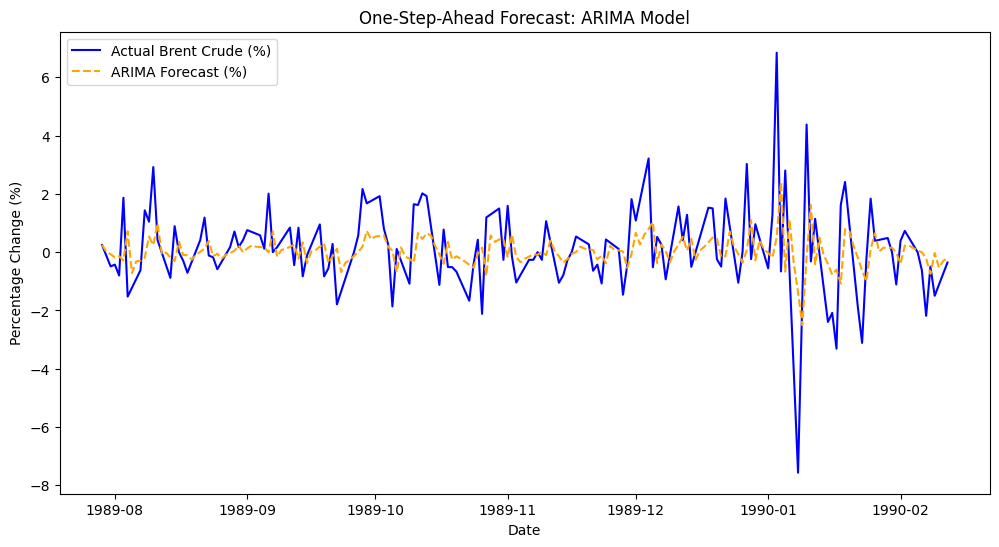

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from statsmodels.tools.eval_measures import rmse
import pandas as pd
import matplotlib.pyplot as plt

Y = merged_data[['y_brent_pct']]
n = Y.shape[0]
n_fcs = int(0.2 * n) 

forecasts_arima = []

for i in tqdm(range(n_fcs), desc="ARIMA Forecast Progress"):
    rolling_train = Y.iloc[:(n - (n_fcs - i))]  
    arima_model = ARIMA(rolling_train, order=(1, 0, 1)) 
    arima_fitted = arima_model.fit()
    forecast = arima_fitted.forecast(steps=1).iloc[0] 
    forecasts_arima.append(forecast)

forecast_arima_df = pd.DataFrame(
    forecasts_arima, index=Y.iloc[-n_fcs:].index, columns=['y_brent_pct_forecast']
)

test_data_arima = Y.iloc[-n_fcs:]

arima_rmse = rmse(test_data_arima['y_brent_pct'], forecast_arima_df['y_brent_pct_forecast'])
print(f'ARIMA One-Step-Ahead RMSE: {arima_rmse:.4f}')
arima_rmsfe = calculate_rmsfe(test_data_arima['y_brent_pct'].values, forecast_arima_df['y_brent_pct_forecast'].values)

plt.figure(figsize=(12, 6))
plt.plot(test_data_arima['y_brent_pct'], label='Actual Brent Crude (%)', color='blue')
plt.plot(forecast_arima_df['y_brent_pct_forecast'], label='ARIMA Forecast (%)', linestyle='--', color='orange')
plt.title('One-Step-Ahead Forecast: ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

This code applies an ARIMA model for one-step-ahead forecasting on time series data. It uses a rolling window approach, where the ARIMA model is refitted on the expanding training set for each test point. The forecasts are collected and stored in a DataFrame for evaluation. The performance of the model is measured using RMSE and RMSFE metrics.

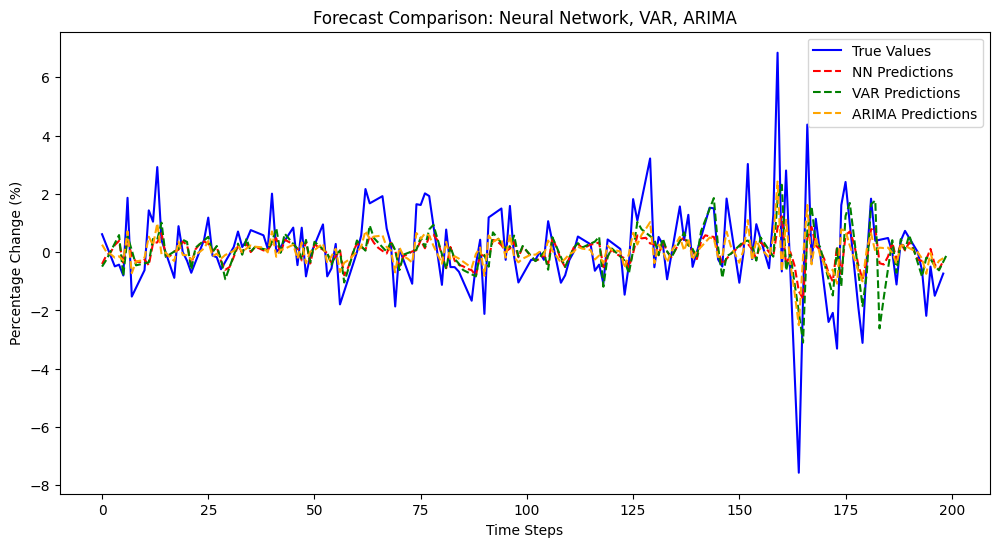


Model Metrics Comparison:
                 Model                            RMSE     RMSFE
0       Neural Network                        1.194248  1.194248
1  Expanding Window NN  <function rmse at 0x1487943a0>  1.187906
2                  VAR                         1.19809  1.198090
3                ARIMA                        1.305951  1.305951


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(inverse_true_values)), inverse_true_values, label='True Values', color='blue')
plt.plot(range(len(predictions)), predictions, label='NN Predictions', color='red', linestyle='--')  # NN predictions
plt.plot(range(len(forecast_df['y_brent_pct_forecast'])), 
         forecast_df['y_brent_pct_forecast'], label='VAR Predictions', color='green', linestyle='--')  # VAR predictions
plt.plot(range(len(forecast_arima_df['y_brent_pct_forecast'])), 
         forecast_arima_df['y_brent_pct_forecast'], label='ARIMA Predictions', color='orange', linestyle='--')  # ARIMA predictions
plt.legend()
plt.title('Forecast Comparison: Neural Network, VAR, ARIMA')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change (%)')
plt.show()

metrics_df = pd.DataFrame({
    'Model': ['Neural Network', 'Expanding Window NN', 'VAR', 'ARIMA'],
    'RMSE': [nn_rmse, rmse, var_rmse, arima_rmse],
    'RMSFE': [nn_rmsfe, expanding_nn_rmsfe, var_rmsfe, arima_rmsfe]
})

print("\nModel Metrics Comparison:")
print(metrics_df)


1. **Neural Network (NN)**: RMSE and RMSFE are approximately 1.194, showing reasonable accuracy.
2. **Expanding Window NN**: RMSFE is 1.188
3. **VAR (Vector Autoregression)**: RMSE and RMSFE are both 1.198, slightly higher than the Neural Network models, indicating slightly lower accuracy.
4. **ARIMA**: RMSE and RMSFE are the highest at 1.306, showing it performed the worst among the compared models.


### Best Performing Model:
The **Expanding Window Neural Network** (Expanding Window NN) performs the best among the compared models, achieving the lowest RMSFE of **1.188**. This indicates that it produces the most accurate forecasts for the test data compared to other models.

### Potential Reasons for Superior Performance:
1. **Dynamic Training Data**: The expanding window approach incorporates new observations into the training set at each step, allowing the model to adapt to the latest trends and reduce bias caused by outdated data.
2. **Neural Network Flexibility**: The NN structure captures non-linear relationships between the features and target variable, which may not be well modeled by linear methods like VAR or ARIMA.
3. **Feature Inclusion**: The inclusion of lagged variables for both Brent and WTI crude prices as features allows the NN to learn intricate interdependencies between the two time series.

### Why Other Models May Lag Behind:
1. **VAR**: While effective for modeling linear interdependencies between time series, VAR may not capture complex non-linear relationships present in this data.
2. **ARIMA**: This model is designed for univariate time series and may struggle to model the potential influence of the WTI series on Brent prices, as well as non-linear dynamics.
3. **Static NN**: The standard Neural Network model lacks the adaptability of the Expanding Window approach, as it uses a fixed training set that might become less relevant over time.

The Expanding Window NN's ability to adapt dynamically and its flexibility in modeling complex relationships makes it the best-performing model in this analysis.

# BONUS

Using LSTM:

Epoch 1/1000
20/20 [==============================] - 2s 15ms/step - loss: 4.1186 - val_loss: 3.9189
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.1074 - val_loss: 3.9118
Epoch 3/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0944 - val_loss: 3.9049
Epoch 4/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0837 - val_loss: 3.8981
Epoch 5/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0732 - val_loss: 3.8916
Epoch 6/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0694 - val_loss: 3.8846
Epoch 7/1000
20/20 [==============================] - 0s 5ms/step - loss: 4.0609 - val_loss: 3.8779
Epoch 8/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0431 - val_loss: 3.8715
Epoch 9/1000
20/20 [==============================] - 0s 5ms/step - loss: 4.0381 - val_loss: 3.8648
Epoch 10/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.0316 - val_loss: 3.857

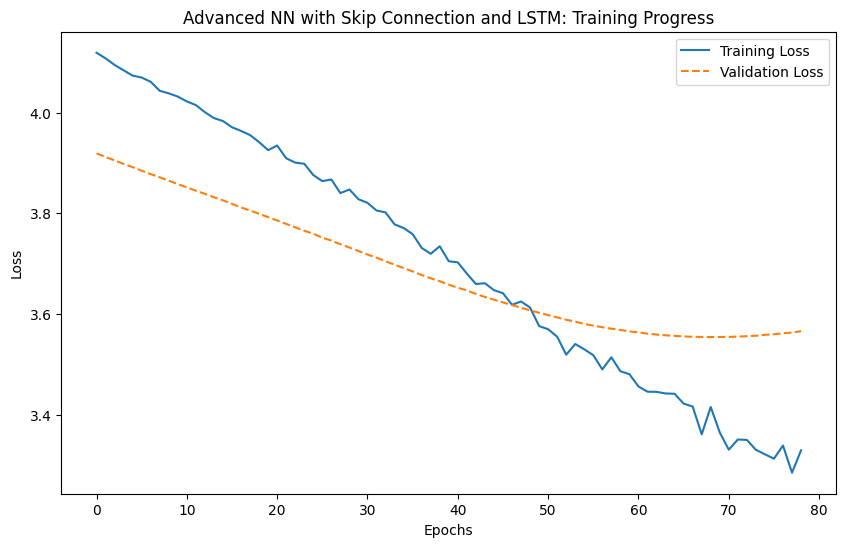

7/7 [==============================] - 0s 2ms/step
Advanced Neural Network RMSE: 1.2324


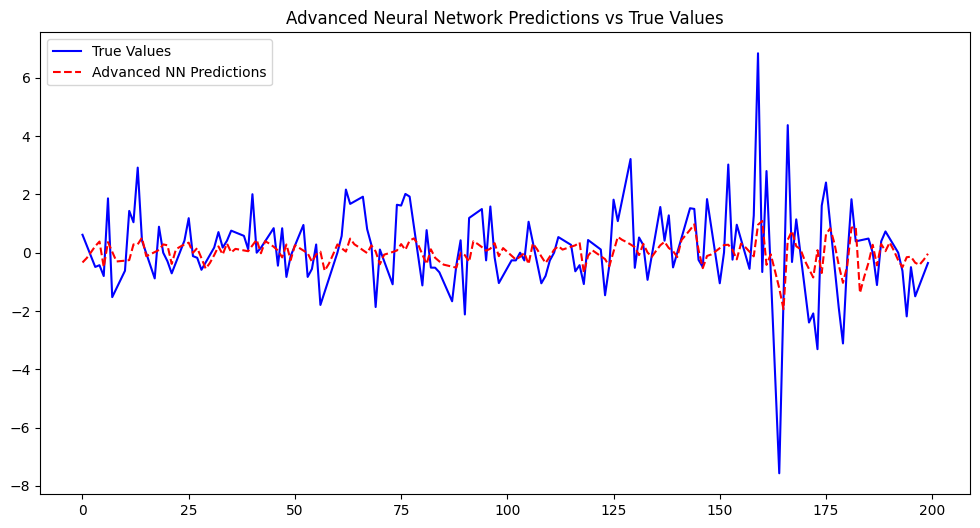

In [12]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

merged_data['Lag_y_brent_pct'] = merged_data['y_brent_pct'].shift(1)
merged_data['Lag_y_wti_pct'] = merged_data['y_wti_pct'].shift(1)
merged_data.dropna(inplace=True)

features = ['Lag_y_brent_pct', 'Lag_y_wti_pct']
X = merged_data[features]
y = merged_data['y_brent_pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

input_layer = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
lstm_layer = LSTM(64, activation='relu', return_sequences=False)(input_layer)
linear_layer = Dense(1)(input_layer[:, -1, :])
combined = Concatenate()([lstm_layer, linear_layer])
dropout = Dropout(0.2)(combined)
output_layer = Dense(1)(dropout)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

history = model.fit(
    X_train_reshaped, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Advanced NN with Skip Connection and LSTM: Training Progress')
plt.legend()
plt.show()

advanced_predictions = model.predict(X_test_reshaped)

advanced_nn_rmse = np.sqrt(mean_squared_error(y_test, advanced_predictions))
print(f'Advanced Neural Network RMSE: {advanced_nn_rmse:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(advanced_predictions, label='Advanced NN Predictions', color='red', linestyle='--')
plt.title('Advanced Neural Network Predictions vs True Values')
plt.legend()
plt.show()
